<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DATA" data-toc-modified-id="DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Target</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model evaluation</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Baseline-with-Numerical-Data" data-toc-modified-id="Baseline-with-Numerical-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baseline with Numerical Data</a></span><ul class="toc-item"><li><span><a href="#pageDepth-+-sessionCount-+-daysSinceLastLession" data-toc-modified-id="pageDepth-+-sessionCount-+-daysSinceLastLession-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>pageDepth + sessionCount + daysSinceLastLession</a></span></li><li><span><a href="#pageDepth-+-sessionCount" data-toc-modified-id="pageDepth-+-sessionCount-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>pageDepth + sessionCount</a></span></li><li><span><a href="#pageDepth-+-sessionCount-+-daysSinceLastLession-+-productSKU_cete" data-toc-modified-id="pageDepth-+-sessionCount-+-daysSinceLastLession-+-productSKU_cete-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>pageDepth + sessionCount + daysSinceLastLession + productSKU_cete</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from scipy import stats
import statsmodels.api as sm
import os

## DATA

### Dataset

In [2]:
data_root="../data/"
datafile=os.path.join(data_root,'dfjoin_Scount_daysSLS_srceMed_city_device_OS_2019_2020_jan21.csv')
df=pd.read_csv(datafile)
print(df.shape)
df.head(3)

/home/dsc/TFM/kschool_masterDS_TFM/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(3936941, 15)


,Unnamed: 0,ga:productSKU,ga:dateHourMinute,ga:pagePath,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:sourceMedium,ga:city,ga:deviceCategory,ga:operatingSystem,ga:productListViews,ga:productListClicks,ga:productDetailViews,ga:productAddsToCart
0,0,1008,201904301452,/parafarmacia/es/,1,1,0,(direct) / (none),Burgos,mobile,iOS,1,0,0,0
1,1,1008,201904301524,/parafarmacia/es/,3,1,0,(direct) / (none),Madrid,desktop,Windows,1,0,0,0
2,2,1008,201904301545,/parafarmacia/es/,7,33,0,merchants.google.com / referral,Zamudio,desktop,Windows,1,0,0,0


In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)
print(df.shape)
print("")
df.info()

(3936941, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936941 entries, 0 to 3936940
Data columns (total 14 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   ga:productSKU            object
 1   ga:dateHourMinute        int64 
 2   ga:pagePath              object
 3   ga:pageDepth             int64 
 4   ga:sessionCount          int64 
 5   ga:daysSinceLastSession  int64 
 6   ga:sourceMedium          object
 7   ga:city                  object
 8   ga:deviceCategory        object
 9   ga:operatingSystem       object
 10  ga:productListViews      int64 
 11  ga:productListClicks     int64 
 12  ga:productDetailViews    int64 
 13  ga:productAddsToCart     int64 
dtypes: int64(8), object(6)
memory usage: 420.5+ MB


### Target

In [4]:
df['ga:productAddsToCart_transf']=df["ga:productAddsToCart"].apply(lambda x: 1 if x>1 else x)

print("No. observations per class")
print(df['ga:productAddsToCart_transf'].value_counts())
print("")

print("% observations per class")
print(100*df['ga:productAddsToCart_transf'].value_counts(normalize=True))

No. observations per class
0    3864256
1      72685
Name: ga:productAddsToCart_transf, dtype: int64

% observations per class
0    98.15377
1     1.84623
Name: ga:productAddsToCart_transf, dtype: float64


## Functions

### Model evaluation

In [5]:
def evaluate(classifier,X_train, X_test, y_train, y_test):
    classifier.fit(X_train,y_train)
    predictions = classifier.predict(X_test)
    probabilities = classifier.predict_proba(X_test)
    print("TRAINING SCORE: " + str(classifier.score(X_train,y_train)))
    print("ACCURACY: " + str(accuracy_score(y_test, predictions)))
    print("PRECISION: " + str(precision_score(y_test, predictions)))
    print("RECALL: " + str(recall_score(y_test, predictions)))
    print("F1 SCORE: " + str(f1_score(y_test, predictions)))
    print("AUC: " + str(roc_auc_score(y_test,probabilities[:, 1])))

    tpr, fpr, thresolds = roc_curve(y_test, probabilities[:, 1])
    plt.plot(tpr, fpr)
    plt.xlabel('fpr')
    plt.ylabel('tpr')

## Random Forest

### Baseline with Numerical Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936941 entries, 0 to 3936940
Data columns (total 15 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   ga:productSKU                object
 1   ga:dateHourMinute            int64 
 2   ga:pagePath                  object
 3   ga:pageDepth                 int64 
 4   ga:sessionCount              int64 
 5   ga:daysSinceLastSession      int64 
 6   ga:sourceMedium              object
 7   ga:city                      object
 8   ga:deviceCategory            object
 9   ga:operatingSystem           object
 10  ga:productListViews          int64 
 11  ga:productListClicks         int64 
 12  ga:productDetailViews        int64 
 13  ga:productAddsToCart         int64 
 14  ga:productAddsToCart_transf  int64 
dtypes: int64(9), object(6)
memory usage: 450.5+ MB


#### pageDepth + sessionCount + daysSinceLastLession

In [7]:
y=df['ga:productAddsToCart_transf']
X=df[['ga:pageDepth','ga:sessionCount','ga:daysSinceLastSession']]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

TRAINING SCORE: 0.9817198128495735
ACCURACY: 0.9813632096367132
PRECISION: 0.34545454545454546
RECALL: 0.007298068481123793
F1 SCORE: 0.014294158740394435
AUC: 0.6715584646541726


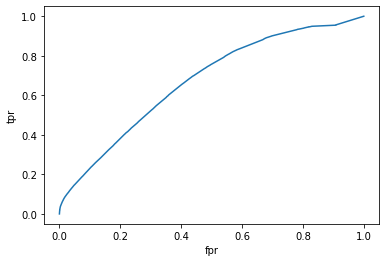

In [8]:
from sklearn.ensemble import RandomForestClassifier
clrf=RandomForestClassifier()
evaluate(clrf,X_train, X_test, y_train, y_test)

In [9]:
print(classification_report(y_test,clrf.predict(X_test)))
clrf_cm = confusion_matrix(y_test,clrf.predict(X_test))
clrf_cm

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    966012
           1       0.35      0.01      0.01     18224

    accuracy                           0.98    984236
   macro avg       0.66      0.50      0.50    984236
weighted avg       0.97      0.98      0.97    984236



array([[965760,    252],
       [ 18091,    133]])

#### pageDepth + sessionCount

In [10]:
y=df['ga:productAddsToCart_transf']
X=df[['ga:pageDepth','ga:sessionCount']]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

TRAINING SCORE: 0.9815978907476365
ACCURACY: 0.9814637952686145
PRECISION: 0.38095238095238093
RECALL: 0.001755926251097454
F1 SCORE: 0.003495739567402229
AUC: 0.6583420959224547


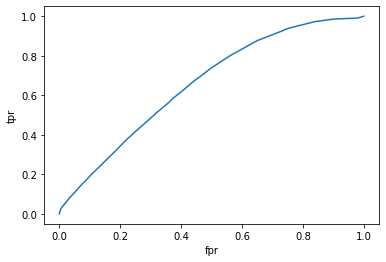

In [11]:
from sklearn.ensemble import RandomForestClassifier
clrf=RandomForestClassifier()
evaluate(clrf,X_train, X_test, y_train, y_test)

In [12]:
print(classification_report(y_test,clrf.predict(X_test)))
clrf_cm = confusion_matrix(y_test,clrf.predict(X_test))
clrf_cm

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    966012
           1       0.38      0.00      0.00     18224

    accuracy                           0.98    984236
   macro avg       0.68      0.50      0.50    984236
weighted avg       0.97      0.98      0.97    984236



array([[965960,     52],
       [ 18192,     32]])

#### pageDepth + sessionCount + daysSinceLastLession + productSKU_cete

In [43]:
#Split data

y=df['ga:productAddsToCart_transf']
X=df[['ga:pageDepth','ga:sessionCount','ga:daysSinceLastSession','ga:productSKU']]
X['ga:productSKU']=X['ga:productSKU'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

<ipython-input-43-e0b6c419d01c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ga:productSKU']=X['ga:productSKU'].astype('str')


In [44]:
# Target encoding of productSKU with train
import category_encoders as ce
encoder=ce.TargetEncoder(cols='ga:productSKU')
X_train['ga:productSKU_cete']=encoder.fit_transform(X_train['ga:productSKU'],y_train)
X_train.head(3)

/home/dsc/TFM/kschool_masterDS_TFM/env/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
<ipython-input-44-7cf7a39bd788>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ga:productSKU_cete']=encoder.fit_transform(X_train['ga:productSKU'],y_train)


,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:productSKU,ga:productSKU_cete
2829355,2,1,0,6908,0.004168
3543383,3,82,0,6809,0.001287
1607926,1,1,0,1047,0.059557


In [45]:
# 'Dictionary' of productSKU target encoding
prod_target_encod= X_train[['ga:productSKU','ga:productSKU_cete']]
prod_target_encod['ga:productSKU']=prod_target_encod['ga:productSKU'].astype('str')
prod_target_encod.drop_duplicates(inplace=True)
print(prod_target_encod.shape)
prod_target_encod.head(3)

<ipython-input-45-84f3a6cf49cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_target_encod['ga:productSKU']=prod_target_encod['ga:productSKU'].astype('str')


(5478, 2)


<ipython-input-45-84f3a6cf49cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_target_encod.drop_duplicates(inplace=True)


,ga:productSKU,ga:productSKU_cete
2829355,6908,0.004168
3543383,6809,0.001287
1607926,1047,0.059557


In [46]:
# productSKU target encoding in test according to fitting on train set:
X_test = X_test.merge(prod_target_encod, left_on='ga:productSKU', right_on='ga:productSKU', how='left')
X_test.head(3)

,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:productSKU,ga:productSKU_cete
0,1,1,0,6925,0.024405
1,14,1,0,5111,0.024561
2,6,1,0,1175,0.048494


In [ ]:
# Checking missing values in 'ga:productSKU_cete':

X_test[X_test['ga:productSKU_cete'].isna()]

In [47]:
# Filling missing values in X_test with the mean of the means:

X_test['ga:productSKU_cete']=X_test['ga:productSKU_cete'].fillna(prod_target_encod['ga:productSKU_cete'].mean())
X_test[X_test['ga:productSKU_cete'].isna()]


In [ ]:
# Drop 'ga:productSKU' in both train and test datasets:

X_train=X_train.drop('ga:productSKU',axis=1)
X_test=X_test.drop('ga:productSKU',axis=1)

In [49]:
X_test.head(3)

,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:productSKU_cete
0,1,1,0,0.024405
1,14,1,0,0.024561
2,6,1,0,0.048494


In [50]:
X_train.head(3)

,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:productSKU_cete
2829355,2,1,0,0.004168
3543383,3,82,0,0.001287
1607926,1,1,0,0.059557


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clrf=RandomForestClassifier()
evaluate(clrf,X_train, X_test, y_train, y_test)

In [22]:
## Target encoding entrenado con conjunto dataset(train + test)

In [20]:
import category_encoders as ce
encoder=ce.TargetEncoder(cols='ga:productSKU')
encoder.fit(df['ga:productSKU'],df['ga:productAddsToCart_transf'])
df['productSKU_cete']=encoder.transform(df['ga:productSKU'],df['ga:productAddsToCart_transf'])
df.head(3)

/home/dsc/TFM/kschool_masterDS_TFM/env/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,ga:productSKU,ga:dateHourMinute,ga:pagePath,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:sourceMedium,ga:city,ga:deviceCategory,ga:operatingSystem,ga:productListViews,ga:productListClicks,ga:productDetailViews,ga:productAddsToCart,ga:productAddsToCart_transf,productSKU_cete
0,1008,201904301452,/parafarmacia/es/,1,1,0,(direct) / (none),Burgos,mobile,iOS,1,0,0,0,0,0.0
1,1008,201904301524,/parafarmacia/es/,3,1,0,(direct) / (none),Madrid,desktop,Windows,1,0,0,0,0,0.0
2,1008,201904301545,/parafarmacia/es/,7,33,0,merchants.google.com / referral,Zamudio,desktop,Windows,1,0,0,0,0,0.0


In [21]:
df[df['ga:productSKU']=='6339']

,ga:productSKU,ga:dateHourMinute,ga:pagePath,ga:pageDepth,ga:sessionCount,ga:daysSinceLastSession,ga:sourceMedium,ga:city,ga:deviceCategory,ga:operatingSystem,ga:productListViews,ga:productListClicks,ga:productDetailViews,ga:productAddsToCart,ga:productAddsToCart_transf,productSKU_cete
127431,6339,202001242237,/parafarmacia/es/,13,3,29,instagram.com / referral,Madrid,mobile,Android,0,0,0,1,1,0.168024
127432,6339,202001251453,/parafarmacia/es/,5,1,0,google / organic,Jerez de la Frontera,mobile,Android,0,0,0,1,1,0.168024
127433,6339,202001251519,/parafarmacia/es/,3,1,0,(direct) / (none),Burgos,tablet,iOS,0,0,0,1,1,0.168024
127434,6339,202001251708,/parafarmacia/es/,3,2,0,(direct) / (none),L'Hospitalet de Llobregat,mobile,iOS,0,0,0,1,1,0.168024
127435,6339,202001252106,/parafarmacia/es/,1,2,1,l.instagram.com / referral,Valladolid,mobile,Android,0,0,0,1,1,0.168024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236293,6339,202003150108,/parafarmacia/es/mas-vendidos,31,1,0,google / organic,Madrid,tablet,Android,0,0,0,1,1,0.168024
236294,6339,202003301955,/parafarmacia/es/mas-vendidos,34,1,0,google / organic,Granada,desktop,Windows,1,0,0,0,0,0.168024
236295,6339,202003311039,/parafarmacia/es/mas-vendidos,5,1,0,google / organic,Madrid,desktop,Windows,1,0,0,0,0,0.168024
236296,6339,202003311058,/parafarmacia/es/mas-vendidos,5,1,0,google / organic,Madrid,desktop,Windows,1,0,0,0,0,0.168024


In [ ]:
y=df['ga:productAddsToCart_transf']
X=df[['ga:pageDepth','ga:sessionCount','ga:daysSinceLastSession','productSKU_cete']]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [32]:
from sklearn.ensemble import RandomForestClassifier
clrf=RandomForestClassifier()
clrf.fit(X_train,y_train)

In [33]:
clrf.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
## evaluar despues pero transformando x_test con diccionario de equivalencias productSKU